In [1]:
## updated codes for Case study 4 (Unit 8): Signal Frontier Analysis

In [2]:
import datetime as dt
import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import data as web
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(12, 6))

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
## set date range
start_dt = dt.datetime(2016, 3, 1)
end_dt = dt.datetime(2019, 3, 1)

In [4]:
## use S&P 500 Index (SPY) to check for market correlations, comparisons for returns
def get_portfolio():    
    port = pd.DataFrame()   
    names = ['NVDA', 'GOOG', 'AMZN', 'AAPL', 'IBM', 'MSFT', 'INTC', 'SPY']
    for stock in names:
        while True:
            try:
                port[stock] = web.get_data_yahoo(stock, start_dt, end_dt)['Adj Close']
                break
            except:
                print('Unable to read stock: {0}, trying again'.format(stock))
    return port

px = get_portfolio()
px = px.loc[~(px==0).all(axis=1)] # strip out days with no trading data for all stocks

In [5]:
## daily adjusted close prices for pizza portfolio + S&P
lastWeekClose = px.tail()
lastWeekClose.to_excel('lastWeekClose.xlsx')

In [6]:
## get standard statistics for portfolio compared to S&P
stat = px.describe()
stat.to_excel('stat.xlsx')

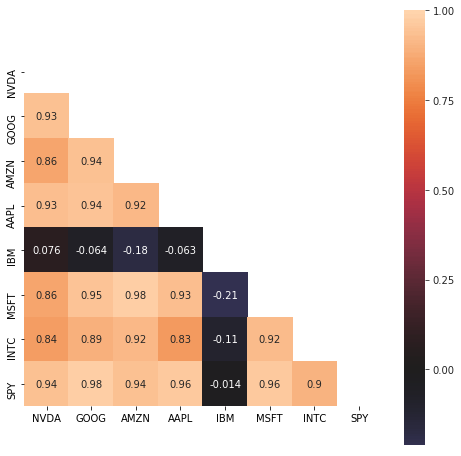

In [7]:
## EDA for linear relationships, including SPY
corr = px.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
with sns.axes_style("darkgrid"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)
plt.savefig('corr.png', dpi=300)

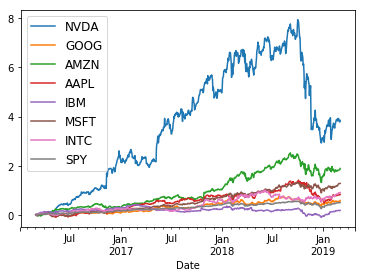

In [8]:
## transform to business day frequency and calculate percentage change
## show cumulative returns over frequency of business days

px = px.asfreq('B').fillna(method='pad') # pad == ffill
rets = px.pct_change()
((1+rets).cumprod()-1).plot()

plt.rc('figure', figsize=(12, 6))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14) 
plt.legend(fontsize=12) 
plt.savefig('cumulativeReturn.png', dpi=300)

In [9]:
## compute momentum over a lookback and rank in ASCENDING order and standardize to get portfolio weights
def calc_mom(price, lookback, lag):
    '''Calculates pct change based on user input shift and lookback period, ranks, then standardizes ranks'''
    mom_ret = price.shift(lag).pct_change(lookback) 
    ranks = mom_ret.rank(axis=1, ascending=True)  
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0) 

In [10]:
compound = lambda x : (1+x).prod()-1     # cumulative returns
daily_sr = lambda x : x.mean() / x.std() # daily sharpe ratio 

## Compute portfolio weights using rank-standardized momentum portfolio
def strat_sr(prices, lb, hold):   
    freq = '%dB' % hold # hold for how many business day
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns: aggregate, multiply and take Sharpe ratio
    port = port.shift(1).resample(freq).first() 
    returns = daily_rets.resample(freq).apply(compound) 
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold) 

In [11]:
## sharpe ratio comparison setup
## iterate over combinations of lookback and holding periods from 10 days to 360 days
from collections import defaultdict

lookbacks = range(10, 360, 10)
holdings = range(10, 360, 10)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        # dont include S&P in analysis of fast food portfolio, index out
        dd[lb][hold] = strat_sr(px.iloc[:, :-1], lb, hold) 
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [12]:
## set up kruskal wallis non-parametric test for lookback periods
## formalize if differences between short and intermediate term strategies 

## considering 90 business days to 180 business days intermediate (grouped)
from scipy.stats import mstats
short = ddf.iloc[:,:4].values.reshape(-1) # flatten vals to 1D array
inter = ddf.iloc[:,4:].values.reshape(-1)

H, pval = mstats.kruskalwallis(short, inter) # non-parametric ANOVA
print('Median of short term, intermediate term Sharpe Ratios for Lookback Period')
print('\nShort:', round(np.median(short),3), '\nIntermediate:',round(np.median(inter),3))

print('\nNon-parametric ANOVA results for short term vs intermediate term groupings')
print(H, pval)


## considering strict definition of short (1 month) and intermediate (6-12 months) periods
## adding a "between" category for analysis purposes
short = ddf.loc[:,:90].values.reshape(-1) # flatten vals to 1D array
between = ddf.loc[:,90:180].values.reshape(-1)
inter = ddf.loc[:,180:].values.reshape(-1)

H, pval = mstats.kruskalwallis(between, inter) # non-parametric ANOVA
print('\n\nStrict Definition: Median of short term, between and intermediate term Sharpe ratios for Lookback Period')
print('Short:', round(np.median(short),3), 
      '\nBetween:', round(np.median(between),3), 
      '\nInter:', round(np.median(inter),3))

print('\nNon-parametric ANOVA results for: "between" vs intermediate term groupings')
print('H:', H, 'p:', pval)

Median of short term, intermediate term Sharpe Ratios for Lookback Period

Short: 0.51 
Intermediate: 0.697

Non-parametric ANOVA results for short term vs intermediate term groupings
42.00517087467432 9.103237714174382e-11


Strict Definition: Median of short term, between and intermediate term Sharpe ratios for Lookback Period
Short: 0.65 
Between: 0.828 
Inter: 0.634

Non-parametric ANOVA results for: "between" vs intermediate term groupings
H: 177.32791342113407 p: 1.857243584096769e-40


In [13]:
## set up kruskal wallis non-parametric test for holding periods
## formalize if differences between short and intermediate term strategies 

# considering 30 business days to 180 business days intermediate (grouped)
short = ddf.iloc[:4,:].values.reshape(-1) # flatten vals to 1D array
inter = ddf.iloc[4:,:].values.reshape(-1)

H, pval = mstats.kruskalwallis(short, inter) # non-parametric ANOVA
print('Median of short term, intermediate term Sharpe Ratios for Holding Period')
print('\nShort:', round(np.median(short),3), '\nIntermediate:',round(np.median(inter),3))

print('\nNon-parametric ANOVA results for short term vs intermediate term groupings')
print(H, pval)


# considering strict definition of short (1 month) and intermediate (6-12 months) periods
# adding a "between" category for analysis purposes
short = ddf.loc[:30,:].values.reshape(-1) # flatten vals to 1D array
between = ddf.loc[30:180,:].values.reshape(-1)
inter = ddf.loc[180:,:].values.reshape(-1)

H, pval = mstats.kruskalwallis(between, inter) # non-parametric ANOVA
print('\n\nStrict Definition: Median of short term, between and intermediate term Sharpe ratios for Holding Period')
print('Short:', round(np.median(short),3), 
      '\nBetween:', round(np.median(between),3), 
      '\nInter:', round(np.median(inter),3))

print('\nNon-parametric ANOVA results for: "between" and intermediate term groupings')
print('H:', H, 'p:', pval)

Median of short term, intermediate term Sharpe Ratios for Holding Period

Short: 0.817 
Intermediate: 0.671

Non-parametric ANOVA results for short term vs intermediate term groupings
29.16568773906467 6.64455512663394e-08


Strict Definition: Median of short term, between and intermediate term Sharpe ratios for Holding Period
Short: 0.814 
Between: 0.774 
Inter: 0.623

Non-parametric ANOVA results for: "between" and intermediate term groupings
H: 103.12232805835765 p: 3.150799476120671e-24


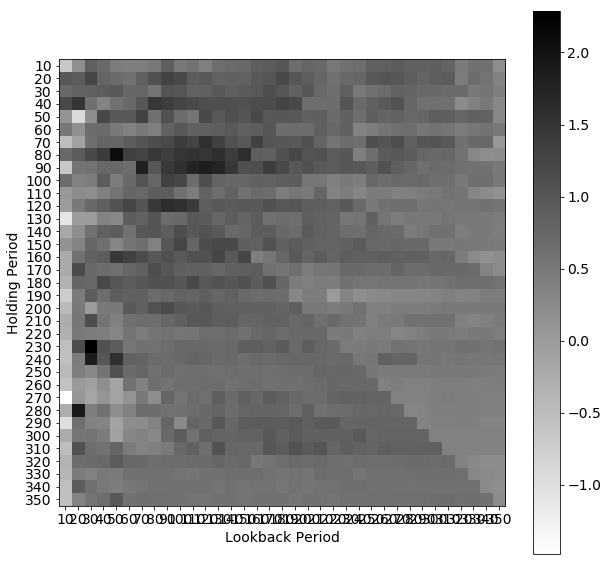

In [14]:
# heatmap from book
def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
    
heatmap(ddf)
plt.savefig('heatmap_book.png', dpi=300)


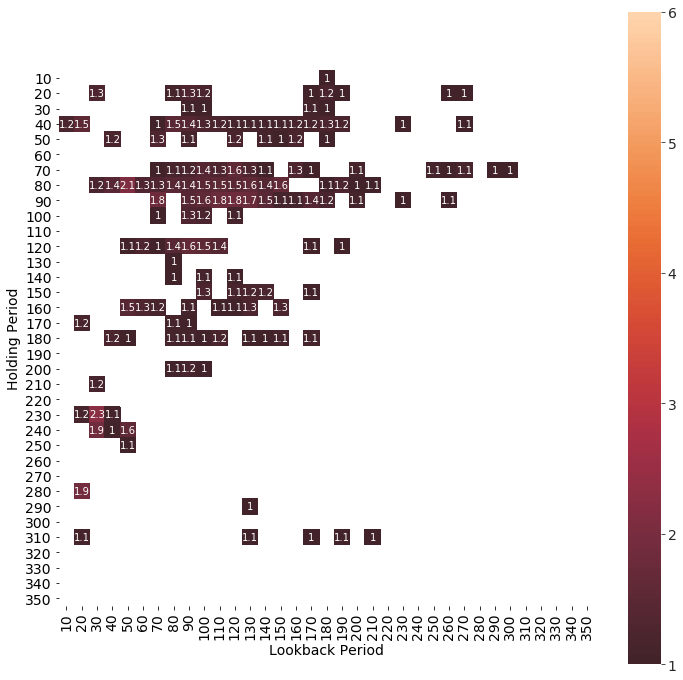

In [15]:
## better heatmap, clusters around intermediate term lookbacks
df = ddf[ddf>1] # show only "good" or above Sharpe ratios
f, ax = plt.subplots(figsize=(12, 12))
with sns.axes_style("darkgrid"):
    ax = sns.heatmap(df, mask=None, vmax=6, center=0, square=True, annot=True)

plt.rc('figure', figsize=(12, 8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12) 
plt.savefig('heatmap_2.png', dpi=300)   

In [16]:
## Calculate S&P cumulative return for same analysis period
((1+px['SPY'].pct_change()).cumprod()-1).iloc[-1]

0.5019802896208327

In [17]:
## Calculate portfolio cumulative return approximation for same analysis period 
## w/equal weight (if we held from day 1 and did not trade momentum)

wts = [.14275, .14275, .14275, .14275, .14275, .14275, .14275]
(((1+px.iloc[:,:-1].pct_change()*wts).cumprod()-1).iloc[-1]).sum() # considering equal weighting

0.9376342241861888

In [18]:
## Annualized Check (should be roughly similar to returns above)¶

In [19]:
# annualized returns for S&P 500
mean_daily_returns = px.iloc[:,-1].pct_change().mean()
portfolio_return = round(np.sum(mean_daily_returns) * 370, 4)
print('S&P return ',portfolio_return)

S&P return  0.2032


In [20]:
# annualized returns for our portfolio considering equal weights
wts = ([.125, .125, .125, .125, .125, .125, .125]) # 0.14275
mean_daily_returns = px.iloc[:,:-1].pct_change().mean()
portfolio_return = round(np.sum(mean_daily_returns * wts) * 360, 4)
print('Equal weighting return ', portfolio_return)

Equal weighting return  0.3541


In [21]:
## use Sharpe ratio to take good scenario from momentum investing results

In [22]:
print('Sharpe for one scenario of momentum: ',strat_sr(px.iloc[:,:-1], 90, 100))

Sharpe for one scenario of momentum:  1.3039569732944456


In [23]:
## get S&P sharpe for same periods to compare
SP_holding = (px['SPY'].pct_change()).resample('100B').apply(compound)
print('S&P 500 Sharpe: ',SP_holding.mean()/SP_holding.std()*np.sqrt(252 / 100))

S&P 500 Sharpe:  1.4566060813673734


In [24]:
## Use VIX index

Text(0, 0.5, 'VIX')

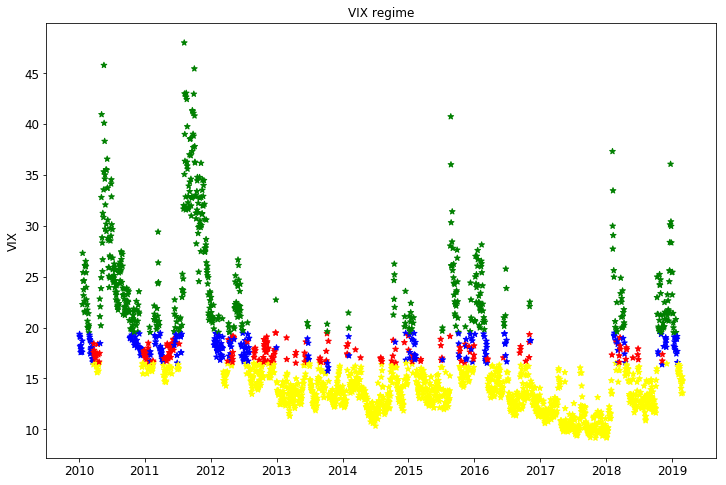

In [25]:
vix = pdr.DataReader('VIXCLS', 'fred').dropna().squeeze()

lower, upper = 16.5, 19.5

# Each term inside parentheses is [False, True, ...]
# Both terms must be True element-wise for a trigger to occur
blue = (vix < upper) & (vix.shift() >= upper)
yellow = (vix < lower) & (vix.shift() >= lower)
green = (vix > upper) & (vix.shift() <= upper)
red = (vix > lower) & (vix.shift() <= lower)

mapping = {1: 'blue', 2: 'yellow', 3: 'green', 4: 'red'}

indicator = pd.Series(np.where(blue, 1., np.where(yellow, 2.,
                      np.where(green, 3., np.where(red, 4., np.nan)))),
                      index=vix.index).ffill().map(mapping).dropna()

vix = vix.reindex(indicator.index)
plt.scatter(vix.index, vix, c=indicator, marker='*')
plt.title('VIX regime')
plt.ylabel('VIX')

In [26]:
## efficient set of portfolios — Efficient Frontier”

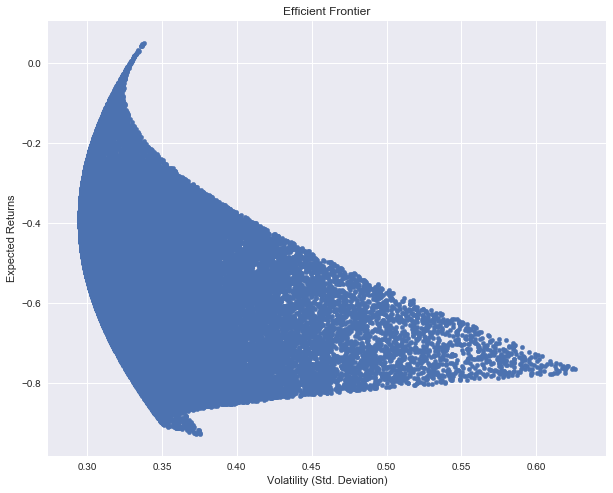

In [27]:
## check with worst performance stocks ('NWL', 'TRUE', 'LOGM') 
import quandl

# get adjusted closing prices of 3 selected companies with Quandl
quandl.ApiConfig.api_key = 'MvzrXUa5F8WQX-6oSUH4' 
selected = ['NWL', 'TRUE', 'LOGM'] 
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2018-1-1', 'lte': '2019-02-01' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

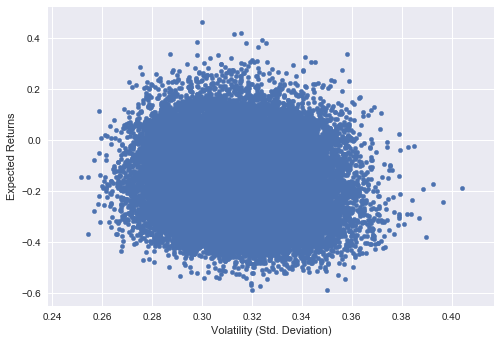

In [28]:
## check performance with  stocks related to computer ('NVDA', 'GOOG', 'AMZN', 'AAPL', 'IBM', 'MSFT', 'INTC') 

# get adjusted closing prices of 7 selected companies with Quandl
quandl.ApiConfig.api_key = 'MvzrXUa5F8WQX-6oSUH4' 
selected = ['NVDA', 'GOOG', 'AMZN', 'AAPL', 'IBM', 'MSFT', 'INTC']

data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2018-3-1', 'lte': '2019-03-01' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', grid=True)

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
# plt.title('Efficient Frontier')
#plt.show()
#plt.tick_params(labelsize=12)

plt.rc('figure', figsize=(8, 6))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14) 

plt.savefig('scatter.png', dpi=300)   

In [29]:
vol_min=df["Volatility"].min()
ret_max=df["Returns"].max()

extremes=df.loc[(df['Volatility'] == df["Volatility"].min()) | (df["Returns"]==df["Returns"].max())]
extremes["Portfolio"]=["Min Volatility","Max Return"]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [30]:
extremes

,Returns,Volatility,NVDA Weight,GOOG Weight,AMZN Weight,AAPL Weight,IBM Weight,MSFT Weight,INTC Weight,Portfolio
45431,-0.146958,0.251376,0.312005,0.034864,0.026359,0.463618,0.112747,0.017891,0.032516,Min Volatility
47504,0.460377,0.300077,0.009712,0.129955,0.043564,0.230723,0.537995,0.001774,0.046277,Max Return


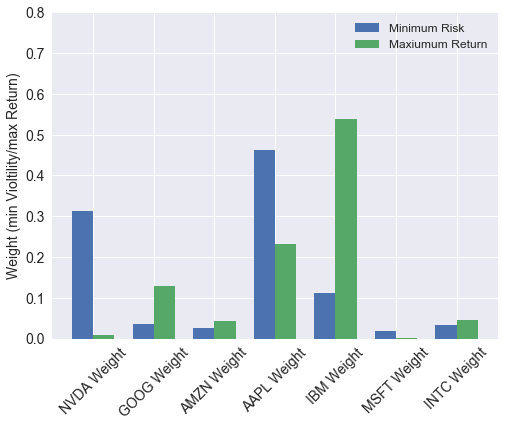

In [31]:
x_labels=list(extremes.columns.values)[2:9]
x=np.arange(len(x_labels))
width=0.35
min_v_y=list(extremes.iloc[0,2:9])
max_r_y=list(extremes.iloc[1,2:9])

ax=plt.subplot()
ax.bar(x,min_v_y,width,label="Minimum Risk")
ax.bar(x+width,max_r_y,width,label="Maxiumum Return")
plt.xticks(x+width/2, x_labels, rotation=45)
plt.ylim(0,0.8)
plt.legend(loc="best")
# plt.title("Stock Weights By Portfolio")
# plt.xlabel("Stocks")
plt.ylabel("Weight (min Violtility/max Return)")

#plt.show()

plt.rc('figure', figsize=(12, 8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12) 
plt.legend(fontsize=12) 
plt.savefig('weight.png', dpi=300)   